In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from datetime import datetime, date
from statsmodels.tsa.arima.model import ARIMA
import warnings

# 加载数据集
df = pd.read_csv('C:/Users/zhouxiinlei/Documents/GitHub/ml_WaterAnalytics/dataset/Lake/Lake_Bilancino.csv')
df.head()

,Date,Rainfall_S_Piero,Rainfall_Mangona,Rainfall_S_Agata,Rainfall_Cavallina,Rainfall_Le_Croci,Temperature_Le_Croci,Lake_Level,Flow_Rate
0,03/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
1,04/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
2,05/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
3,06/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
4,07/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.44,0.31


In [50]:
data_info = df.info()
data_description = df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6603 entries, 0 to 6602
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  6603 non-null   object 
 1   Rainfall_S_Piero      6026 non-null   float64
 2   Rainfall_Mangona      6026 non-null   float64
 3   Rainfall_S_Agata      6026 non-null   float64
 4   Rainfall_Cavallina    6026 non-null   float64
 5   Rainfall_Le_Croci     6026 non-null   float64
 6   Temperature_Le_Croci  6025 non-null   float64
 7   Lake_Level            6603 non-null   float64
 8   Flow_Rate             6582 non-null   float64
dtypes: float64(8), object(1)
memory usage: 464.4+ KB


Date                      0
Rainfall_S_Piero        577
Rainfall_Mangona        577
Rainfall_S_Agata        577
Rainfall_Cavallina      577
Rainfall_Le_Croci       577
Temperature_Le_Croci    578
Lake_Level                0
Flow_Rate                21
dtype: int64


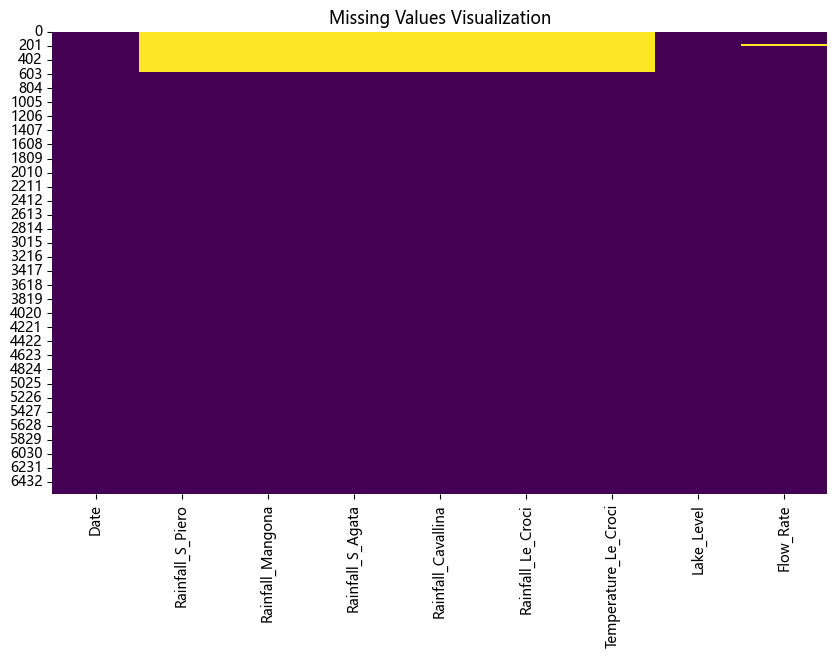

In [51]:
# 缺失值统计
missing_counts = df.isnull().sum()
print(missing_counts)

# 缺失值可视化
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Visualization')
plt.show()

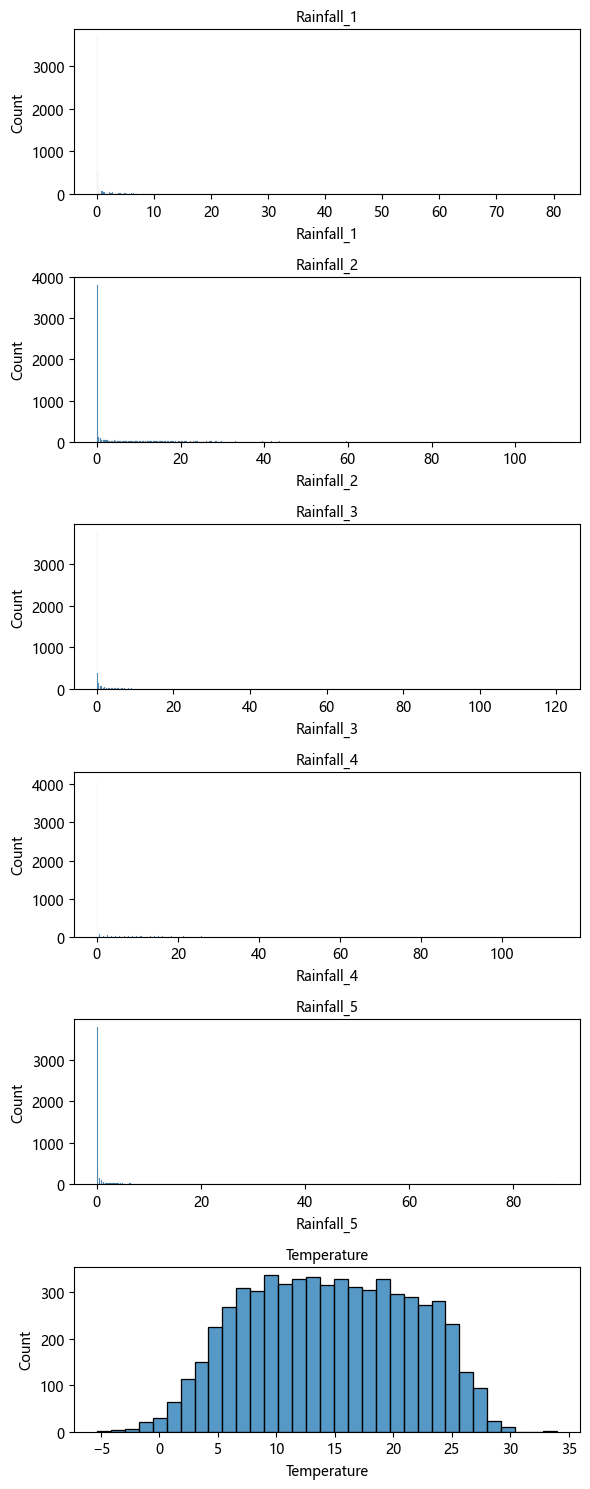

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 读取数据（请确保路径正确）
bilancino = pd.read_csv('C:/Users/zhouxiinlei/Documents/GitHub/ml_WaterAnalytics/dataset/Lake/Lake_Bilancino.csv', usecols=lambda column: column != 'Date')
bilancino = bilancino[bilancino.Temperature_Le_Croci.notna()].reset_index(drop=True)

# 准备列名称
bilancino.columns = ['Rainfall_1', 'Rainfall_2', 'Rainfall_3', 'Rainfall_4', 'Rainfall_5', 'Temperature', 'Lake_level', 'Flow_rate']
feature_list = ['Rainfall_1', 'Rainfall_2', 'Rainfall_3', 'Rainfall_4', 'Rainfall_5', 'Temperature']

# 创建一个子图网格，所有子图都在一张图上
f, ax = plt.subplots(nrows=6, ncols=1, figsize=(6, 15))  # 这里我们保持了原始的子图大小

# 为每个特征绘制直方图
for i, feature in enumerate(feature_list):
    sns.histplot(bilancino[feature], kde=False, ax=ax[i])  # 使用histplot代替distplot，并保持原始的美学风格
    ax[i].set_title(feature, fontsize=10)

# 优化布局并显示图表
plt.tight_layout()
plt.show()


In [53]:
for name in feature_list:
    data = np.array(bilancino[name])
    q25 = np.percentile(data, 5)
    q75 = np.percentile(data, 95)
    lower_lim = q25 - 4*(q75-q25)
    upper_lim = q75 + 4*(q75-q25)
    outlier_indices = np.where((data < lower_lim) | (data > upper_lim))
    bilancino[name][outlier_indices[0]] = np.nan
#缺失值填充
for name in feature_list:
    bilancino[name] = bilancino[name].interpolate()
#数据归一化
scaler = MinMaxScaler()
bilancino[bilancino.columns] = scaler.fit_transform(bilancino[bilancino.columns])

MSE: 0.02479509189985382
RMSE: 0.15746457347560378
MAE: 0.10234296212641925
R2 score: 0.556798855325698
Best n 1000
Best Lam 0.1


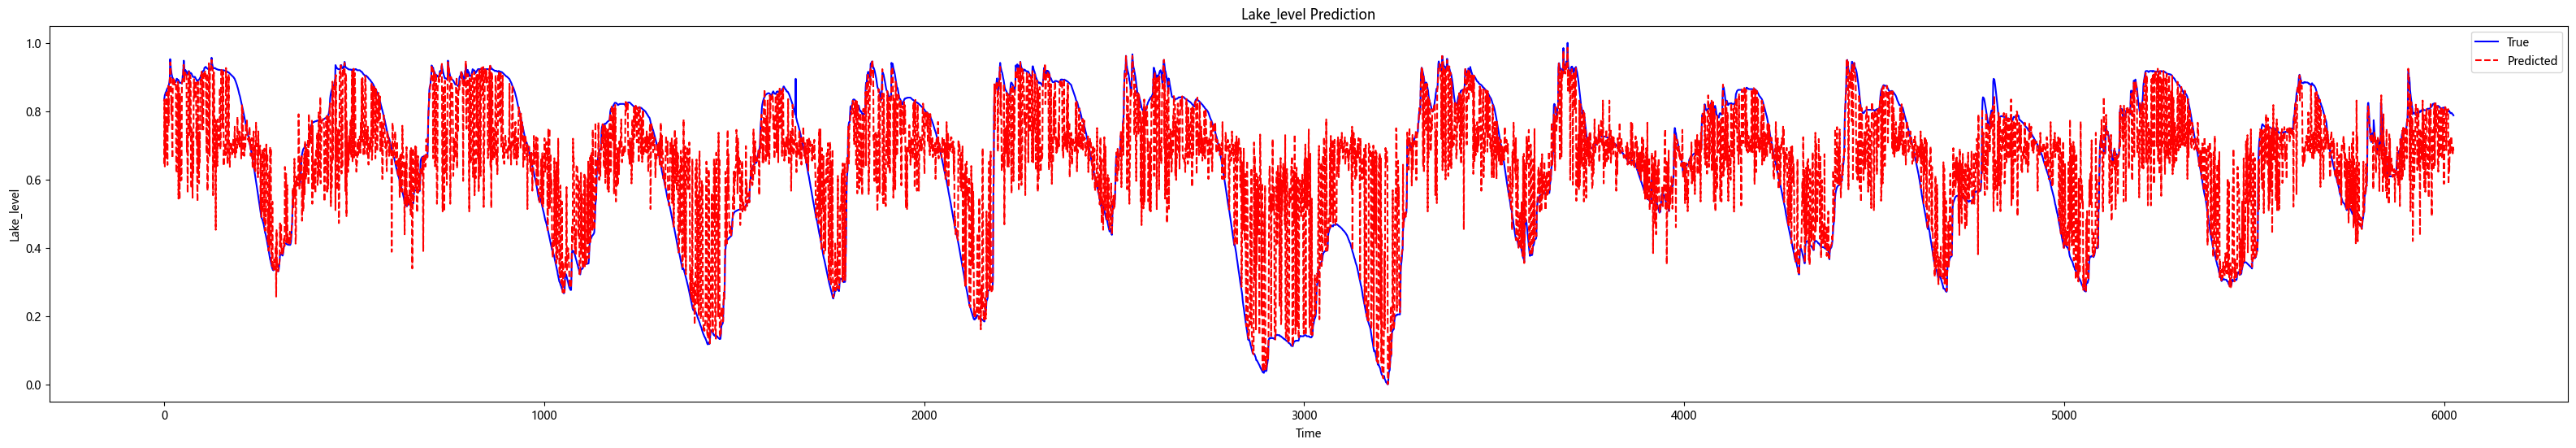

In [54]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
X = bilancino[feature_list].values
y = bilancino[output[0]].values
num = [i*100 for i in range(1, 11)]
lams = [i*0.1 for i in range(1, 9)]
Best_r2_score = 0
Best_n = 0
Best_lam = 0
for n in num:
    for lam in lams:
        model = xgb.XGBRegressor(learning_rate=0.1, n_estimators=n, reg_lambda=lam)
        model.fit(X, y)
        y_pred = model.predict(X)
        if Best_r2_score < r2_score(y, y_pred):
            Best_r2_score = r2_score(y, y_pred)
            Best_n = n
            Best_lam = lam
            Best_model = model
y_pred = Best_model.predict(X)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

# 打印性能指标
print('MSE:', mse)
print('RMSE:', rmse)
print('MAE:', mae)
print('R2 score:', r2)
print('Best n', Best_n)
print('Best Lam', Best_lam)

plt.figure(figsize=(40, 6)) 
plt.xlabel('Time')
plt.ylabel('Lake_level')
plt.title('Lake_level Prediction')
plt.plot(y, label='True', color='blue')  

plt.plot(y_pred, label='Predicted', color='red', linestyle='--')  # 您可以选择任何您喜欢的颜色

plt.xlabel('Time')
plt.ylabel('Lake_level')
plt.title('Lake_level Prediction')
plt.legend()
plt.show()

MSE: 0.39840013507432215
RMSE: 0.6311894605222129
MAE: 0.6081075296880949
R2 score: -74.63525257466927


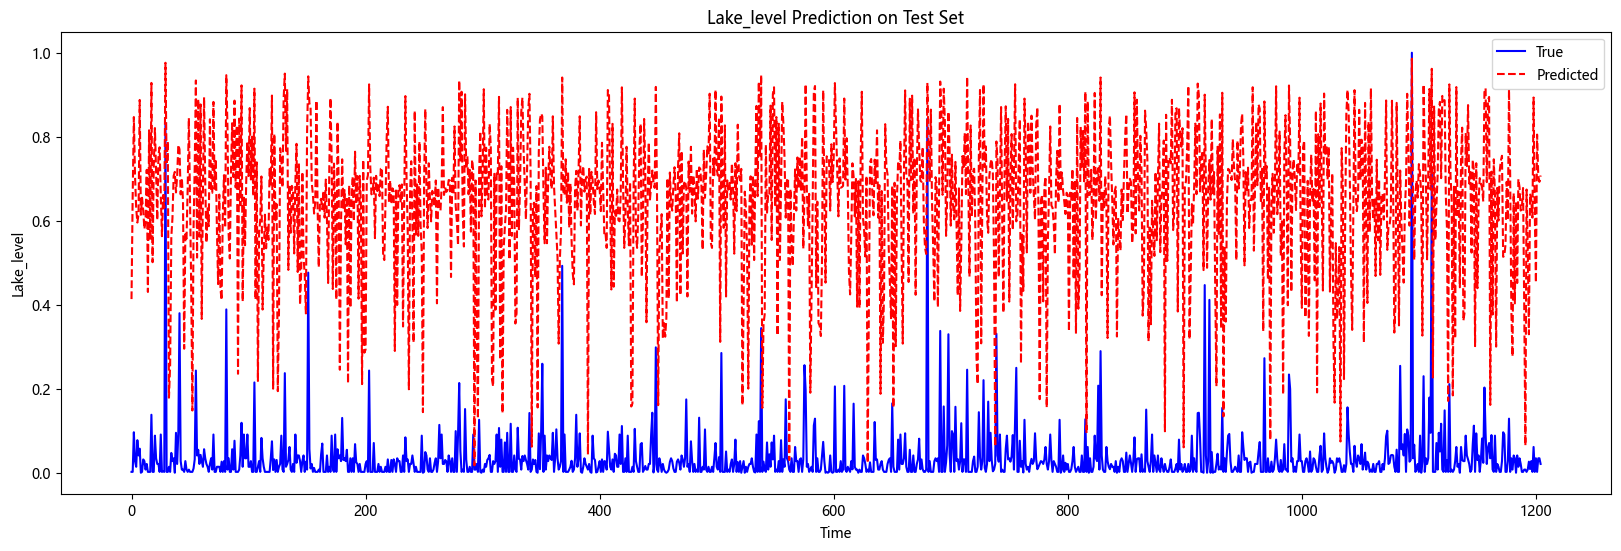

In [55]:
from sklearn.model_selection import train_test_split

# 准备数据
X = bilancino[feature_list].values
y = bilancino[output[1]].values

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 可以选择不同的划分比例

# 初始化最佳分数和模型参数
Best_r2_score = 0
Best_n = 0
Best_lam = 0

# 模型训练用的参数范围
num = [i*100 for i in range(1, 11)]
lams = [i*0.1 for i in range(1, 9)]

for n in num:
    for lam in lams:
        model = xgb.XGBRegressor(learning_rate=0.1, n_estimators=n, reg_lambda=lam)
        model.fit(X_train, y_train)  # 注意：我们在训练集上训练模型
        y_pred = model.predict(X_test)  # 在测试集上评估模型
        current_score = r2_score(y_test, y_pred)  # 使用测试集标签计算R^2分数
        if Best_r2_score < current_score:
            Best_r2_score = current_score
            Best_n = n
            Best_lam = lam
            Best_model = model

# 使用最佳模型在测试集上做出预测，并计算性能指标
y_pred = Best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 打印性能指标
print('MSE:', mse)
print('RMSE:', rmse)
print('MAE:', mae)
print('R2 score:', r2)

# 绘图
plt.figure(figsize=(20, 6)) 
plt.plot(y_test, label='True', color='blue')  # 测试集的真实标签
plt.plot(y_pred, label='Predicted', color='red', linestyle='--')  # 测试集的预测值

plt.xlabel('Time')
plt.ylabel('Lake_level')
plt.title('Lake_level Prediction on Test Set')
plt.legend()
plt.show()


In [56]:
bilancino = bilancino[bilancino.Temperature_Le_Croci.notna()].reset_index(drop=True) #删去2004.1.2前的数据
feature_list = ['Rainfall_1', 'Rainfall_2', 'Rainfall_3', 'Rainfall_4', 'Rainfall_5', 'Temperature']
bilancino.columns = ['Date', 'Rainfall_1', 'Rainfall_2', 'Rainfall_3', 'Rainfall_4', 'Rainfall_5', 'Temperature', 'Lake_level', 'Flow_rate']
output = ['Lake_level', 'Flow_rate']
bilancino['Date'] = pd.to_datetime(bilancino.Date, format='%d/%m/%Y')

AttributeError: 'DataFrame' object has no attribute 'Temperature_Le_Croci'

Text(0, 0.5, 'Temperature')

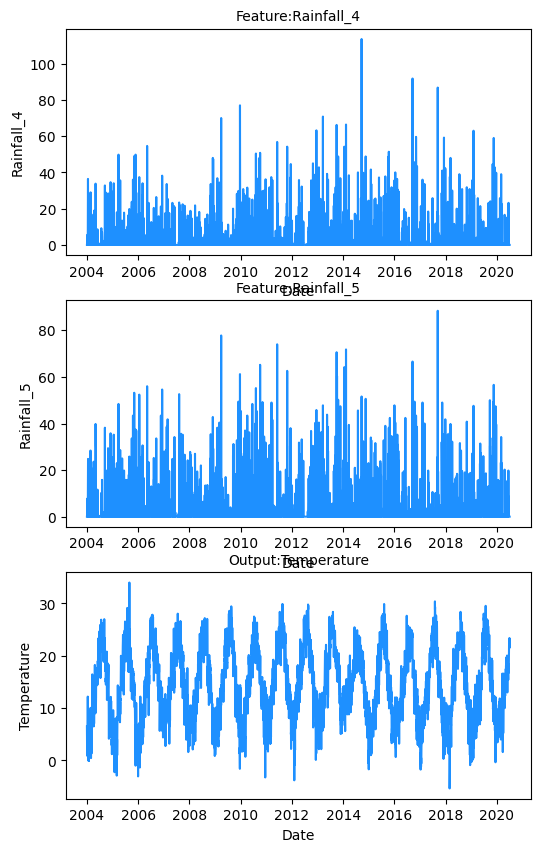

In [ ]:
bilancino['Flow_rate'] = bilancino['Flow_rate'].interpolate()   #缺失值处理
f, ax = plt.subplots(nrows=3, ncols=1, figsize=(6, 10))
sns.lineplot(x=bilancino.Date, y=bilancino.Rainfall_4.fillna(np.inf), ax=ax[0], color='dodgerblue')
ax[0].set_title('Feature:Rainfall_4', fontsize=10)
ax[0].set_ylabel(ylabel='Rainfall_4', fontsize=10)
sns.lineplot(x=bilancino.Date, y=bilancino.Rainfall_5.fillna(np.inf), ax=ax[1], color='dodgerblue')
ax[1].set_title('Feature:Rainfall_5', fontsize=10)
ax[1].set_ylabel(ylabel='Rainfall_5', fontsize=10)
sns.lineplot(x=bilancino.Date, y=bilancino.Temperature.fillna(np.inf), ax=ax[2], color='dodgerblue')
ax[2].set_title('Output:Temperature', fontsize=10)
ax[2].set_ylabel(ylabel='Temperature', fontsize=10)

<Figure size 640x480 with 0 Axes>

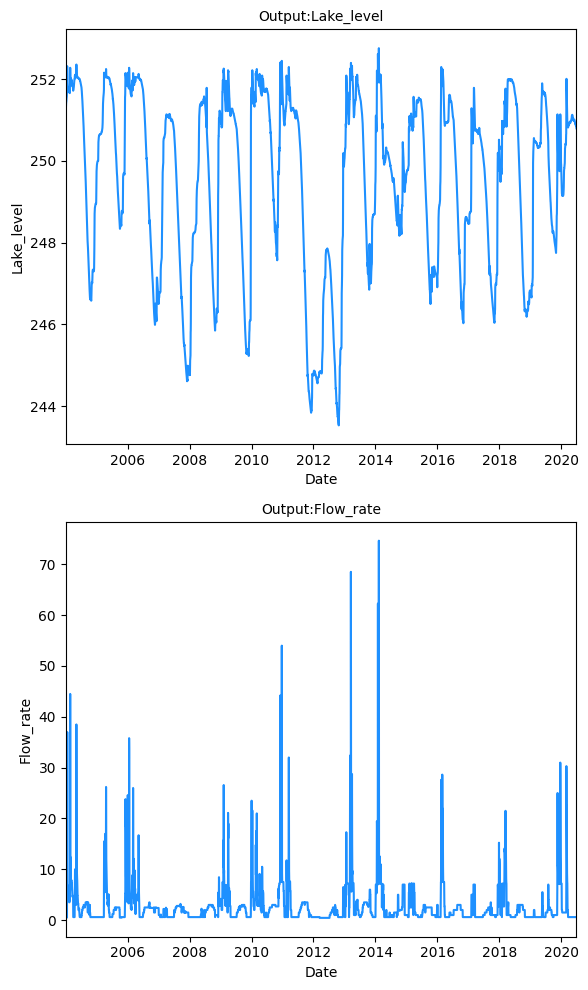

In [ ]:
from datetime import datetime, date
for i in range(3):
    ax[i].set_xlim([date(2004, 1, 2), date(2020, 6, 30)])
plt.tight_layout()
plt.show()
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(6, 10))
sns.lineplot(x=bilancino.Date, y=bilancino.Lake_level.fillna(np.inf), ax=ax[0], color='dodgerblue')
ax[0].set_title('Output:Lake_level', fontsize=10)
ax[0].set_ylabel(ylabel='Lake_level', fontsize=10)
sns.lineplot(x=bilancino.Date, y=bilancino.Flow_rate.fillna(np.inf), ax=ax[1], color='dodgerblue')
ax[1].set_title('Output:Flow_rate', fontsize=10)
ax[1].set_ylabel(ylabel='Flow_rate', fontsize=10)
for i in range(2):
    ax[i].set_xlim([date(2004, 1, 2), date(2020, 6, 30)])
plt.tight_layout()
plt.show()

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from datetime import datetime, date
from statsmodels.tsa.arima.model import ARIMA
import warnings

In [69]:
warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'Microsoft YaHei'
# 初步绘制数据集的样本热力图
bilancino = pd.read_csv('C:/Users/zhouxiinlei/Documents/GitHub/ml_WaterAnalytics/dataset/Lake/Lake_Bilancino.csv')
bilancino = bilancino[bilancino.Temperature_Le_Croci.notna()].reset_index(drop=True) #删去2004.1.2前的数据
feature_list = ['Rainfall_1', 'Rainfall_2', 'Rainfall_3', 'Rainfall_4', 'Rainfall_5', 'Temperature']
bilancino.columns = ['Date', 'Rainfall_1', 'Rainfall_2', 'Rainfall_3', 'Rainfall_4', 'Rainfall_5', 'Temperature', 'Lake_level', 'Flow_rate']
output = ['Lake_level', 'Flow_rate']
bilancino['Date'] = pd.to_datetime(bilancino.Date, format='%d/%m/%Y')


In [70]:
bilancino['Flow_rate'] = bilancino['Flow_rate'].interpolate()   #缺失值处理

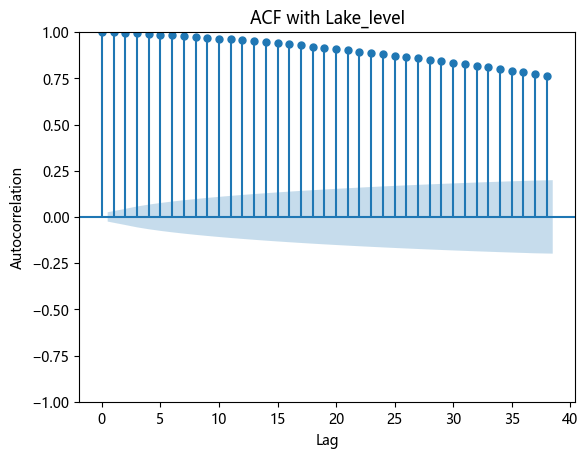

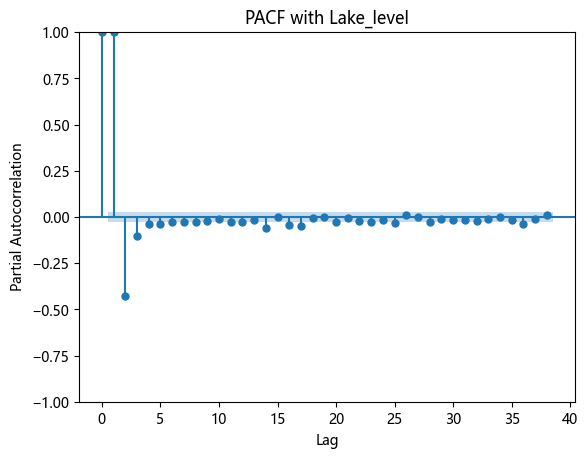

MSE: 0.013959392168382545
RMSE: 0.1181498716392978
MAE: 0.04668354795801447
R-squared: 0.9894685751378867


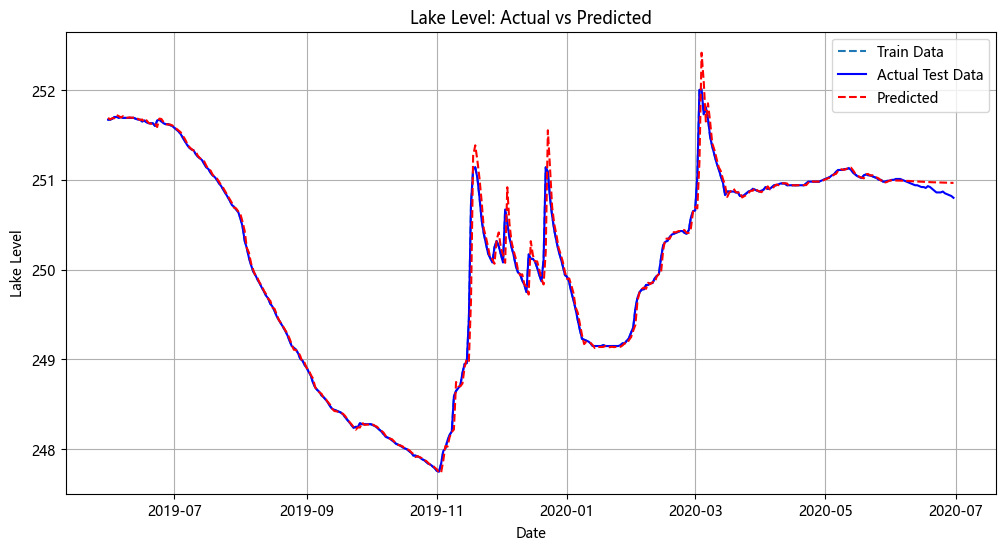

In [71]:
bilancino.set_index('Date', inplace=True)
train_data = bilancino.loc[:'2020-05-30', 'Lake_level']
test_data = bilancino.loc['2019-05-31':, 'Lake_level']
plot_acf(bilancino['Lake_level'], alpha=0.05)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('ACF with Lake_level')
plt.show()
plot_pacf(bilancino['Lake_level'], alpha=0.05)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('PACF with Lake_level')
plt.show()
model = ARIMA(train_data, order=(1, 1, 16))
model_fit = model.fit()
start_date = test_data.index[0]
end_date = test_data.index[-1]
predictions = model_fit.predict(start=start_date, end=end_date)
mse = mean_squared_error(test_data, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data, predictions)
r2 = r2_score(test_data, predictions)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R-squared: {r2}')
# 绘图以比较原始数据和预测
plt.figure(figsize=(12, 6))  # 改变图的大小以便更清楚地看到结果

# 绘制训练数据，但仅包括预测范围内的部分，以便更好地比较
plt.plot(train_data.loc[start_date:], label='Train Data', linestyle='--')

plt.plot(test_data, label='Actual Test Data', color='blue')
plt.plot(predictions, label='Predicted', color='red', linestyle='--')

# 为图表添加更多细节
plt.title('Lake Level: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Lake Level')
plt.legend()
plt.grid(True)
plt.show()

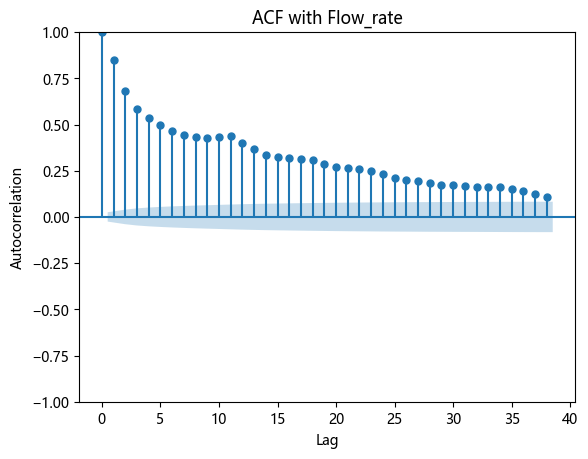

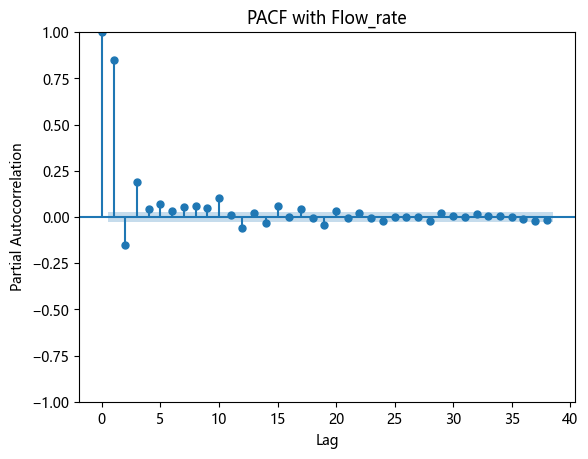

MSE: 4.387254722323797
RMSE: 2.094577456749642
MAE: 0.644996352202852
R-squared: 0.8261033946773205


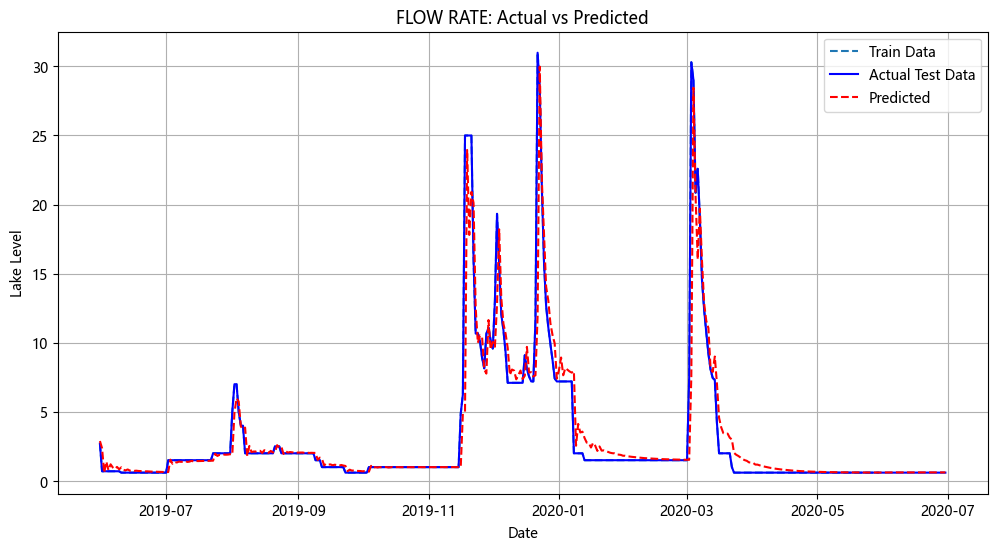

In [72]:
train_data = bilancino.loc[:'2020-05-30', 'Flow_rate']
test_data = bilancino.loc['2019-05-31':, 'Flow_rate']
plot_acf(bilancino['Flow_rate'], alpha=0.05)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('ACF with Flow_rate')
plt.show()
plot_pacf(bilancino['Flow_rate'], alpha=0.05)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('PACF with Flow_rate')
plt.show()
model = ARIMA(train_data, order=(2, 1, 10))
model_fit = model.fit()
start_date = test_data.index[0]
end_date = test_data.index[-1]
predictions = model_fit.predict(start=start_date, end=end_date)
mse = mean_squared_error(test_data, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data, predictions)
r2 = r2_score(test_data, predictions)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R-squared: {r2}')
# 绘图以比较原始数据和预测
plt.figure(figsize=(12, 6))  # 改变图的大小以便更清楚地看到结果

# 绘制训练数据，但仅包括预测范围内的部分，以便更好地比较
plt.plot(train_data.loc[start_date:], label='Train Data', linestyle='--')

plt.plot(test_data, label='Actual Test Data', color='blue')
plt.plot(predictions, label='Predicted', color='red', linestyle='--')

# 为图表添加更多细节
plt.title('FLOW RATE: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Lake Level')
plt.legend()
plt.grid(True)
plt.show()
